### Import

In [1]:
import pandas as pd
import gensim
import numpy as np
import re, string
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.manifold import TSNE
from sklearn import preprocessing
warnings.filterwarnings(action='ignore')

### Word2Vec Model

In [2]:
class Word2Vec:
    
    def __init__(self, vocab_size=0, embedding_dim=16, optimizer='sgd', epochs=10000):
        self.vocab_size=vocab_size
        self.embedding_dim=5
        self.epochs=epochs
        if optimizer=='adam':
            self.optimizer = tf.optimizers.Adam()
        else:
            self.optimizer = tf.optimizers.SGD(learning_rate=0.1)

    def train(self, x_train=None, y_train=None):
        self.W1 = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim]))
        self.b1 = tf.Variable(tf.random.normal([self.embedding_dim])) #bias
        self.W2 = tf.Variable(tf.random.normal([self.embedding_dim, self.vocab_size]))
        self.b2 = tf.Variable(tf.random.normal([self.vocab_size]))
        for _ in range(self.epochs):
            with tf.GradientTape() as t:
                hidden_layer = tf.add(tf.matmul(x_train,self.W1),self.b1)
                output_layer = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, self.W2), self.b2))
                cross_entropy_loss = tf.reduce_mean(
                    -tf.math.reduce_sum(y_train * tf.math.log(output_layer), axis=[1]))
            grads = t.gradient(cross_entropy_loss, [self.W1, self.b1, self.W2, self.b2])
            self.optimizer.apply_gradients(zip(grads,[self.W1, self.b1, self.W2, self.b2]))
        if(_ % 1000 == 0):
            print(cross_entropy_loss)

    def vectorized(self, word_idx):
        return (self.W1+self.b1)[word_idx]

### Load Corpus

In [3]:
fullstr = ''
with open('../../data/books/mobydick','r') as f:
    for line in f:
        line = line.rstrip().lower()
        line = re.sub(r'[^a-zA-Z.]',' ', line)
        line = line.lower()
        fullstr = fullstr + ' ' + line
raw_sentences = fullstr.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())

### Create the data 

In [4]:
data = []
WINDOW_SIZE = 2
for sentence in tqdm(sentences):
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence)) + 1] :
            if nb_word != word:
                data.append([word, nb_word])

100%|████████████████████████████████████| 7367/7367 [00:00<00:00, 14193.21it/s]


### Build dictionaries

In [5]:
words = []
for word in fullstr.split():
    if word != '.': 
        if (word[-1] == '.'):
            word = word[:-1]
        words.append(word)
words = set(words)
word2int = {}
int2word = {}
vocab_size = len(words) 
for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

### To One Hot Vectors

In [ ]:
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp
x_train = [] 
y_train = []
for data_word in data:
    x_train.append(to_one_hot(word2int[ data_word[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ data_word[1] ], vocab_size))
x_train = np.asarray(x_train, dtype='float32')
y_train = np.asarray(y_train, dtype='float32')    

### Training

In [17]:
w2v = Word2Vec(vocab_size=vocab_size, optimizer='adam', epochs=10000)
w2v.train(x_train, y_train)

Metal device set to: Apple M2


2023-02-01 13:00:16.749837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-01 13:00:16.750591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Get all vectors

In [38]:
vectors = []
for word in words:
    vector = w2v.vectorized(word2int[word])
    vectors.append(vector.numpy())
vectors = np.array(vectors)
vectors.shape

(7, 5)

### Create Manifold

In [39]:
model = TSNE(n_components=2, random_state=0,perplexity=5)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)
normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

### Plot

the -0.6191737
he 0.3678362
king -0.23765941
she -0.7682743
queen -0.8808076
is -0.98210204
royal -0.06701836


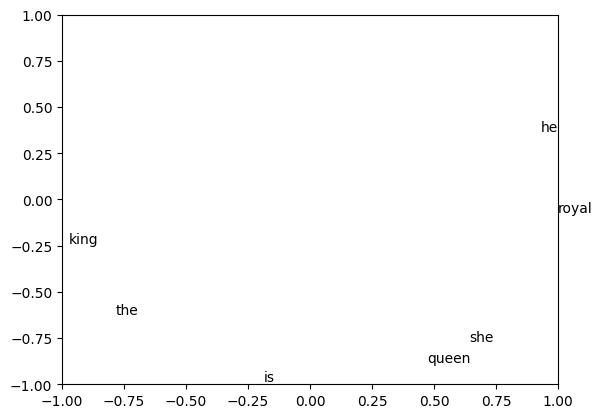

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
plt.show()